In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

# Load Kuzushiji-MNIST dataset
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

In [11]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [12]:
# Autoencoder
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.039327871054410934
Epoch [2/5], Loss: 0.02792263589799404
Epoch [3/5], Loss: 0.02447223663330078
Epoch [4/5], Loss: 0.01892860233783722
Epoch [5/5], Loss: 0.019670432433485985


In [13]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Partition

In [14]:
# cluster: 6, CLient: 10

In [15]:
alpha_values = [0.1, 0.5, 1, 5, 10, 20]
num_clients = 10
num_clusters = 6
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic Dataloaders

In [16]:
trainingset = train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 4

In [17]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=num_clients, alpha=alpha)

    # Normal loader classic
    classic_client_loaders = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic.values()
    ]

    local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]

    optimizer = optim.SGD(trial_model_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_strong, train_loader, optimizer, log_interval, train_losses, train_counter)

    test_losses_classic_strong = []
    test_fashion(trial_model_strong,test_loader,test_losses_classic_strong)

    

    for round_idx in range(rounds_classic):
        
        print(f"Round {round_idx + 1}/{rounds_classic}")
    
        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,test_loader,test_losses)

        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)

        # Save results for non-clustered classic
        if alpha not in results["classic"]:
            results["classic"][alpha] = {"losses": [], "accuracy": []}

        results["classic"][alpha]["losses"].extend(test_losses)
        results["classic"][alpha]["accuracy"].extend(test_accuracies_classic)


    ######################
    import cluster

    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data

    # Clustered loader classic
    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_classic = []
            for client_idx, client_model in enumerate(local_models_classic_strong[0:num_clusters]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_classic.append(client_weights)
                
        
            global_weights_classic = federated_averaging(local_weights_classic)
        
        
            distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
        
            distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
            test_losses = []
            test_fashion(global_model_classic_strong,test_loader,test_losses)
    
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data = data.view(data.shape[0], -1)
                    output = global_model_classic_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if alpha not in clusteredResults["classic"]:
                clusteredResults["classic"][alpha] = {"losses": [], "accuracy": []}
    
            clusteredResults["classic"][alpha]["losses"].extend(test_losses)
            clusteredResults["classic"][alpha]["accuracy"].extend(test_accuracies_classic)

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316336
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.283454
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.315551
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.300179
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288529
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.270949
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.267949
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.291444
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.262211
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.245188
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.247500
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.239357
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.217642
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.207436
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.188569
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.200631
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.171941
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.169030
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.076976
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6630, Accuracy: 7935/10000 (79%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.308813
Train Epoch: 1 [640/8317 (8%)]	Loss: 2.139660
Train Epoch: 1 [1280/8317 (15%)]	Loss: 1.886705
Train Epoch: 1 [1920/8317 (23%)]	Loss: 1.218345
Train Epoch: 1 [2560/8317 (31%)]	Loss: 1.022592
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.941739
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.671904
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.831569
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.777416
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.866753
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.692274
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.481904
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.470799
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.553687
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.557876
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.601760
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.491186
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.209848
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.355609
Train Epoch: 2

In [19]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [2.114086869049072, 1.8599435619354248, 1.58485480594635, 1.4052169120788573], 'accuracy': [25.64, 36.55, 48.51, 54.58]}, 0.5: {'losses': [0.9729539094924927, 0.8733310007095337, 0.8323567504882813, 0.794106632232666], 'accuracy': [68.2, 72.05, 73.38, 74.8]}, 1: {'losses': [0.6837137748241424, 0.6606716333389282, 0.6407302776813507, 0.6285692409992218], 'accuracy': [78.96, 79.79, 80.52, 80.89]}, 5: {'losses': [0.5552733708381653, 0.5453003717422485, 0.5356855767726898, 0.5293325495719909], 'accuracy': [83.48, 83.73, 84.17, 84.4]}, 10: {'losses': [0.5054553223133087, 0.5033683454990387, 0.4948503391742706, 0.4926556745529175], 'accuracy': [85.47, 85.64, 85.92, 86.04]}, 20: {'losses': [0.49191708846092225, 0.4925801701068878, 0.49165856637954714, 0.48835286655426025], 'accuracy': [86.66, 86.6, 86.61, 86.84]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {0.1: {'losses': [1.4074360456466675, 1.37080147590

# PCA Dataloaders

In [20]:
# pca 
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()


In [ ]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)
    
    pca_client_loaders = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca.values()
    ]

    local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

    # Pca strong
    optimizer = optim.SGD(trial_model_pca_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_pca_strong, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)

    test_losses_pca_strong = []
    test_fashion(trial_model_pca_strong,train_loader_reduced_pca,test_losses_pca_strong)

    rounds_pca = 4
    for round_idx in range(rounds_pca):
        
        print(f"Round {round_idx + 1}/{rounds_pca}")
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_classic.append(accuracy)
    
        # Save results for non-clustered classic
        if alpha not in results["pca"]:
            results["pca"][alpha] = {"losses": [], "accuracy": []}
    
        results["pca"][alpha]["losses"].extend(test_losses)
        results["pca"][alpha]["accuracy"].extend(test_accuracies_classic)

    ##############33
    import cluster
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]


    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_pca = []
            for client_idx, client_model in enumerate(local_models_pca_strong[0:num_clusters]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_pca.append(client_weights)
                
        
            global_weights_pca = federated_averaging(local_weights_pca)
        
            distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
        
            distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
            test_losses = []
            test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader_pca:
                    data = data.view(data.shape[0], -1)
                    output = global_model_pca_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader_pca.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if alpha not in clusteredResults["pca"]:
                clusteredResults["pca"][alpha] = {"losses": [], "accuracy": []}
    
            clusteredResults["pca"][alpha]["losses"].extend(test_losses)
            clusteredResults["pca"][alpha]["accuracy"].extend(test_accuracies_classic)
        

Running experiment with alpha: 0.1 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318875
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.258085
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.247504
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.211752
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.089077
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.042206
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.992580
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.871430
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.632241
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.713789
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.568984
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.339449
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.378786
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.299443
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.340621
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.142607
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.993706
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.043939
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.857283
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

# Autoencoder Dataloader

In [ ]:
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()

In [24]:
for alpha in alpha_values:
    print(f"Running experiment with alpha: {alpha} ")
    partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

    # Normal loader autoencoder
    auto_client_loaders = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto.values()
    ]

    local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

    # Auto strong
    optimizer = optim.SGD(trial_model_auto_strong.parameters(), lr=learning_rate,
                          momentum=momentum)
    
    train_losses = []
    train_counter = []
    
    for epoch in range(1, n_epochs + 1):  
        train_fashion(epoch, trial_model_auto_strong, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

    test_losses_auto_strong = []
    test_fashion(trial_model_auto_strong,reduced_train_loader_auto,test_losses_auto_strong)

    rounds_auto = 4
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for non-clustered classic
        if alpha not in results["autoencoder"]:
            results["autoencoder"][alpha] = {"losses": [], "accuracy": []}
        
        results["autoencoder"][alpha]["losses"].extend(test_losses)
        results["autoencoder"][alpha]["accuracy"].extend(test_accuracies_classic)

    ######################
    import cluster
    cluster = cluster.Cluster(num_clusters=num_clusters)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_clusters]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for clustered classic
        if alpha not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][alpha] = {"losses": [], "accuracy": []}
        
        clusteredResults["autoencoder"][alpha]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][alpha]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 4 [3840/11167 (34%)]	Loss: 0.061818
Train Epoch: 4 [4480/11167 (40%)]	Loss: 0.224076
Train Epoch: 4 [5120/11167 (46%)]	Loss: 0.086654
Train Epoch: 4 [5760/11167 (51%)]	Loss: 0.027517
Train Epoch: 4 [6400/11167 (57%)]	Loss: 0.046942
Train Epoch: 4 [7040/11167 (63%)]	Loss: 0.075201
Train Epoch: 4 [7680/11167 (69%)]	Loss: 0.046368
Train Epoch: 4 [8320/11167 (74%)]	Loss: 0.048810
Train Epoch: 4 [8960/11167 (80%)]	Loss: 0.037319
Train Epoch: 4 [9600/11167 (86%)]	Loss: 0.068898
Train Epoch: 4 [10240/11167 (91%)]	Loss: 0.046763
Train Epoch: 4 [10880/11167 (97%)]	Loss: 0.019672
Train Epoch: 5 [0/11167 (0%)]	Loss: 0.072681
Train Epoch: 5 [640/11167 (6%)]	Loss: 0.042911
Train Epoch: 5 [1280/11167 (11%)]	Loss: 0.030192
Train Epoch: 5 [1920/11167 (17%)]	Loss: 0.019964
Train Epoch: 5 [2560/11167 (23%)]	Loss: 0.063150
Train Epoch: 5 [3200/11167 (29%)]	Loss: 0.051564
Train Epoch: 5 [3840/11167 (34%)]	Loss: 0.100885
Train Epoch: 5 [4480/11167 (40%)]	Loss: 0.021860
Train Epoch: 5 [5120/111

In [25]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {0.1: {'losses': [2.114086869049072, 1.8599435619354248, 1.58485480594635, 1.4052169120788573], 'accuracy': [25.64, 36.55, 48.51, 54.58]}, 0.5: {'losses': [0.9729539094924927, 0.8733310007095337, 0.8323567504882813, 0.794106632232666], 'accuracy': [68.2, 72.05, 73.38, 74.8]}, 1: {'losses': [0.6837137748241424, 0.6606716333389282, 0.6407302776813507, 0.6285692409992218], 'accuracy': [78.96, 79.79, 80.52, 80.89]}, 5: {'losses': [0.5552733708381653, 0.5453003717422485, 0.5356855767726898, 0.5293325495719909], 'accuracy': [83.48, 83.73, 84.17, 84.4]}, 10: {'losses': [0.5054553223133087, 0.5033683454990387, 0.4948503391742706, 0.4926556745529175], 'accuracy': [85.47, 85.64, 85.92, 86.04]}, 20: {'losses': [0.49191708846092225, 0.4925801701068878, 0.49165856637954714, 0.48835286655426025], 'accuracy': [86.66, 86.6, 86.61, 86.84]}}, 'pca': {0.1: {'losses': [2.1954381175994873, 2.0245033277511597, 1.8862293621063233, 1.7847583351135254], 'accuracy': [3

# Plot


Non-Clustered Results:
classic:
  Average Loss: {0.1: 1.741025537252426, 0.5: 0.8681870732307434, 1: 0.6534212317109107, 5: 0.5413979672312736, 10: 0.49908242038488393, 20: 0.49112717287540436}
  Average Accuracy: {0.1: 41.31999999999999, 0.5: 72.1075, 1: 80.03999999999999, 5: 83.945, 10: 85.76750000000001, 20: 86.67750000000001}
pca:
  Average Loss: {0.1: 1.9727322856426242, 0.5: 1.3755720829010007, 1: 1.0678349153995512, 5: 0.9045428018331528, 10: 0.8200006450176239, 20: 0.7711339035034179}
  Average Accuracy: {0.1: 49.879999999999995, 0.5: 73.50750000000001, 1: 79.635, 5: 80.985, 10: 80.9525, 20: 80.635}
autoencoder:
  Average Loss: {0.1: 1.735275221300125, 0.5: 0.7847052129983902, 1: 0.598957857120037, 5: 0.5172317428708076, 10: 0.4994738689303398, 20: 0.5093787139058112}
  Average Accuracy: {0.1: 40.82, 0.5: 75.4725, 1: 81.3675, 5: 84.7225, 10: 85.9175, 20: 86.12500000000001}


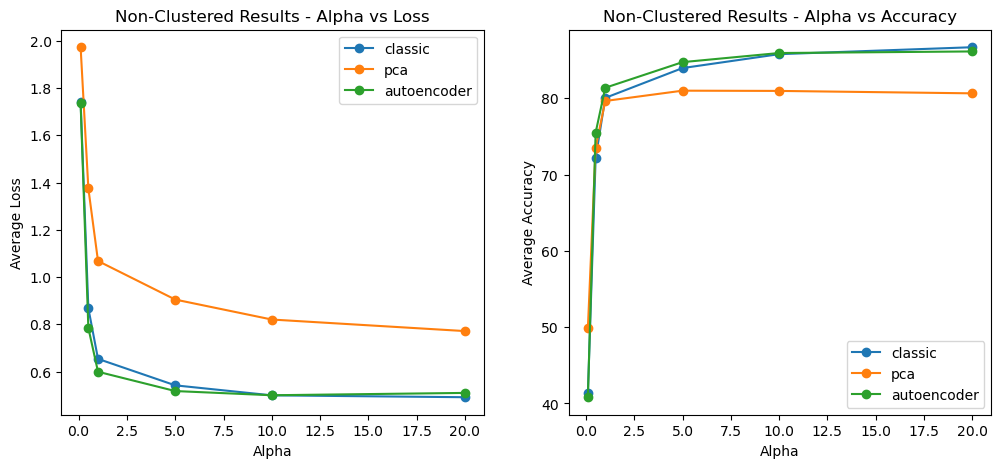


Clustered Results:
classic:
  Average Loss: {0.1: 1.3584286918640136, 0.5: 0.7554576493382454, 1: 0.6140134435772896, 5: 0.5213159724235534, 10: 0.5018829215764999, 20: 0.5042171940326691}
  Average Accuracy: {0.1: 59.675, 0.5: 76.26249999999999, 1: 81.5875, 5: 84.75750000000001, 10: 86.2675, 20: 86.7575}
pca:
  Average Loss: {0.1: 1.6522508355140686, 0.5: 1.1990895383358002, 1: 0.9739744995117188, 5: 0.8630196290254593, 10: 0.8005521436452865, 20: 0.7707463218927384}
  Average Accuracy: {0.1: 58.5275, 0.5: 77.015, 1: 80.52250000000001, 5: 80.6275, 10: 80.3175, 20: 79.68}
autoencoder:
  Average Loss: {0.1: 1.0637311053276062, 0.5: 0.6666416492342949, 1: 0.5423025111556052, 5: 0.5057928996682166, 10: 0.5053837781071663, 20: 0.5225054661631584}
  Average Accuracy: {0.1: 64.78750000000001, 0.5: 78.8275, 1: 83.55499999999999, 5: 85.3825, 10: 86.05, 20: 86.19}


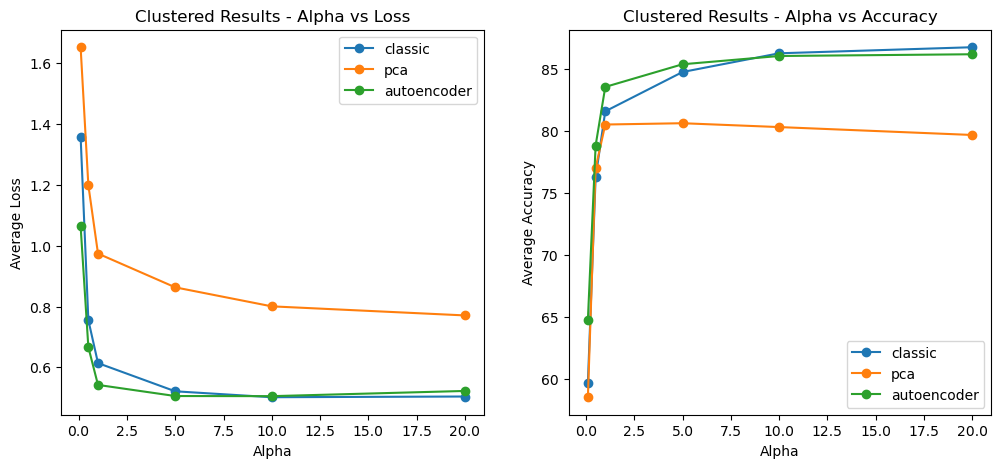

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Alpha vs Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('Alpha')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Alpha vs Accuracy')
    plt.legend()
    
    #plt.savefig(filename)
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")